In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'

# A new stereo-video approach to characterize and monitor reef fish spawning aggregations based on the first record of a spawning aggregation of the Mexican hogfish Bodianus diplotaenia in the Galapagos Marine Reserve

Data are available in the `share` directory of this package:

In [2]:
from path import path
data = path('../share')

The [pandas](http://pandas.pydata.org/pandas-docs/stable/index.html) package is used for data manipulation.

In [3]:
from pandas import DataFrame, read_csv, np

The [matplotlib](http://matplotlib.org/) package is used for $2$D data visualization.

In [4]:
from matplotlib import pyplot as plt

Import [RPy2](http://rpy.sourceforge.net/) package for R analyses embedded in the IPython notebook

In [5]:
import rpy2
%reload_ext rpy2.ipython
%Rpush data

In [6]:
import math

## Biomass

In order to fit the allometric relationship between the length and weight, we use the linear model

$$ \log(w_i) = \alpha + \beta \times \log(l_i) + \epsilon_i,$$

where

* $i$ denotes an individual,
* $w_i$ denotes its weight,
* $l_i$ denotes its length,
* $\alpha$ denotes the intercept (theoritical weight of fish of length $0.0$),
* $\beta$ denotes the slope.
* $\epsilon_i$ denotes the Gaussian noise.

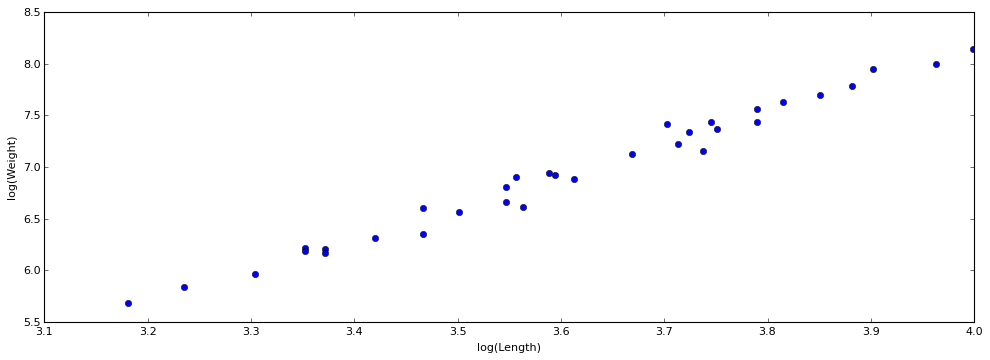

In [7]:
biomass = read_csv(data/'biomass.csv', sep=',')
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
logx = True
logy = True
x = biomass.FL
y = biomass.W
if logx:
    x = [math.log(x) for x in x]
if logy:
    y = [math.log(y) for y in y]       
plt.plot(x,y,'o')
axes.set_xlabel('log(Length)')
axes.set_ylabel('log(Weight)')

In [8]:
%%R
biomass = read.csv(paste(data, 'biomass.csv', sep=.Platform$file.sep), header=T, sep=',')
reg = lm('log(W) ~ log(FL)', data=biomass)
coefficients = summary(reg)$coefficients
prd = predict(reg)
summary(reg)


Call:
lm(formula = "log(W) ~ log(FL)", data = biomass)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.190493 -0.045270  0.000104  0.055658  0.187602 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.19841    0.25540  -16.44   <2e-16 ***
log(FL)      3.08765    0.07067   43.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08529 on 31 degrees of freedom
Multiple R-squared:  0.984,	Adjusted R-squared:  0.9835 
F-statistic:  1909 on 1 and 31 DF,  p-value: < 2.2e-16



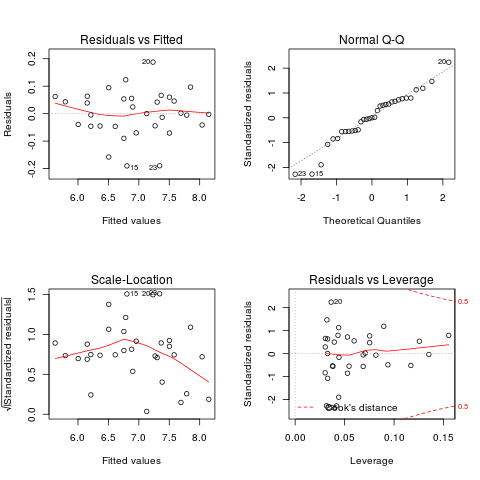

In [9]:
%%R
par(mfrow=c(2,2))
plot(reg)

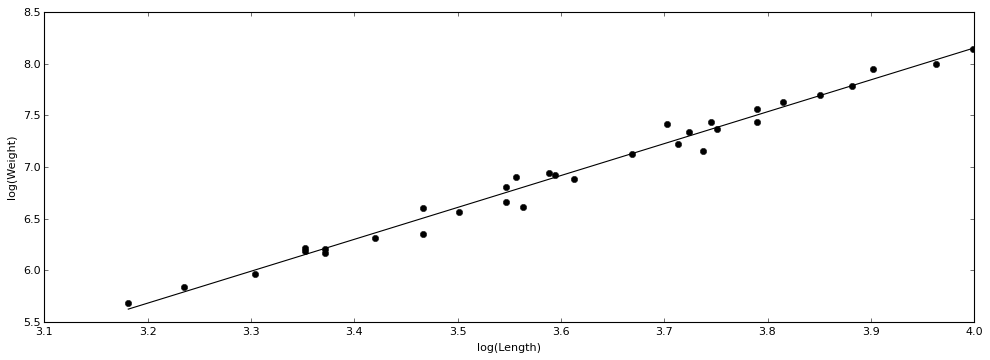

In [10]:
%Rpull prd
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
plt.plot(x,y,'ko')
plt.plot(x,list(prd),'k-')
axes.set_xlabel('log(Length)')
axes.set_ylabel('log(Weight)')
fig.savefig('lW-lL.svg')

In [11]:
math.sqrt(np.mean([(math.exp(i)-math.exp(j))**2 for i, j in zip(prd, y)]))/np.mean(y)

15.172684452104935

In [12]:
for i, j in zip(list(prd), y):
    print math.exp(i), math.exp(j), math.exp(i)-math.exp(j), (math.exp(i)-math.exp(j))**2/math.exp(j)

277.160041175 295.0 -17.8399588246 1.07886146055
327.604105182 342.0 -14.3958948177 0.605970139189
404.661110457 389.0 15.6611104574 0.630515117631
469.386992572 500.0 -30.6130074282 1.8743124476
469.386992572 488.0 -18.6130074282 0.709926322794
498.390492945 496.0 2.39049294466 0.0115210816905
498.390492945 476.0 22.3904929447 1.05322305526
579.656053404 554.0 25.656053404 1.18814634706
668.793876927 571.0 97.793876927 16.7489358396
668.793876927 735.0 -66.206123073 5.96360643858
743.670301153 710.0 33.6703011529 1.59674532356
857.887795043 905.0 -47.1122049566 2.45255232693
857.887795043 784.0 73.8877950434 6.96352838823
884.093182398 1000.0 -115.906817602 13.4343903665
901.334844558 745.0 156.334844558 32.806152514
974.237958077 1030.0 -55.7620419232 3.01884011597
992.645745902 1017.0 -24.3542540981 0.583215037044
1050.15212037 979.0 71.1521203661 5.17121984943
1247.87026002 1248.0 -0.129739980937 1.34875502031e-05
1384.33756299 1670.0 -285.66243701 48.864088574
1432.33548414 1370.0

## Selecting a site

In [13]:
transect = read_csv(data/'transects_bis.csv', sep=',')
temp = transect[transect.Period == 'C3']
temp = temp[temp.Site == 'Punta Suarez']
temp

,Site,Period,Transectos,Length,Species,Number,Stage
115,Punta Suarez,C3,Punta Suarez C3,372,Bodianus diplotaenia,1,M
116,Punta Suarez,C3,Punta Suarez C3,358,Bodianus diplotaenia,1,M


In [14]:
sum(temp.Length.apply(math.log)), sum(temp.Number)

(11.799426840673846, 2)

In [15]:
transect

,Site,Period,Transectos,Length,Species,Number,Stage
0,Bahia Gardner norte,C1,Bahia Gardner norte C1,377,Bodianus diplotaenia,1,M
1,Bahia Gardner norte,C1,Bahia Gardner norte C1,197,Bodianus diplotaenia,1,F
2,Bahia Gardner norte,C1,Bahia Gardner norte C1,249,Bodianus diplotaenia,1,F
3,Bahia Gardner norte,C1,Bahia Gardner norte C1,256,Bodianus diplotaenia,1,F
4,Bahia Gardner norte,C1,Bahia Gardner norte C1,284,Bodianus diplotaenia,1,F
5,Bahia Gardner norte,C1,Bahia Gardner norte C1,255,Bodianus diplotaenia,1,F
6,Bahia Gardner norte,C1,Bahia Gardner norte C1,363,Bodianus diplotaenia,1,M
7,Bahia Gardner norte,C3,Bahia Gardner norte C3,332,Bodianus diplotaenia,1,AD
8,Bahia Gardner norte,C3,Bahia Gardner norte C3,166,Bodianus diplotaenia,1,F
9,Bahia Gardner norte,C3,Bahia Gardner norte C3,224,Bodianus diplotaenia,1,F


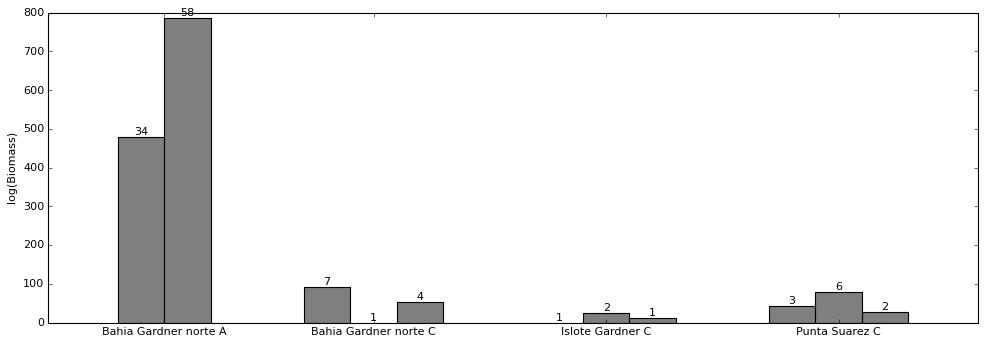

In [16]:
transect = read_csv(data/'transect.csv', sep=',')
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
width = .5
x = 0
delta = 1.
_delta = delta
transects = sorted(set(transect.Transect))
cmap = plt.get_cmap('gray', len(transects))
xticks = []
for t in range(len(transects)):
    ttransect = transect[transect.Transect == transects[t]]
    y = -4.19841*ttransect.Diplotaenia + 3.08765 * ttransect.LogLength
    rects = axes.bar(np.array(range(x, x+len(y)))*width-width/2+_delta, y, width, color=(0., 0., 0., .5))#cmap(t))
    for rect, nb in zip(rects, ttransect.Diplotaenia.tolist()):
        height = rect.get_height()
        if not np.isfinite(height):
            height = 0
        axes.text(rect.get_x()+rect.get_width()/2., height+1., '%d'%int(nb),
                ha='center', va='bottom')
    xticks.append((x+len(y)/2.)*width-width/2+_delta)
    x += len(y)
    _delta += delta
axes.set_xticks(xticks)
axes.set_xticklabels(transects)
#axes.set_xlabel('Site')
axes.set_ylabel('log(Biomass)')
fig.savefig('transect.svg')

On this table the results of the linear model are displayed.
In particular:

* $\alpha = -4.19841$ (first column on line (Intercept)) and significantly different from $0.0$ (last column on line (Intercept)),
* $\beta = 3.09$ (first column on line log(FL)) and significantly different from $0.0$ (last column on line log(FL)).

The following plots can be used to verify the validity of linear model underlying hypotheses.
In particular:

* The top-left graph enable the verification of the homoscedasticity.
* The top-right graph enable the verification of the normality of errors.

And the graphic below illustrate the adjustment of the linear model (red line) to the data (blue dots). 

We are now interested into converting randomly collected lengths in the video (see graph below) into weights using the previous length-weight allometric relationship.

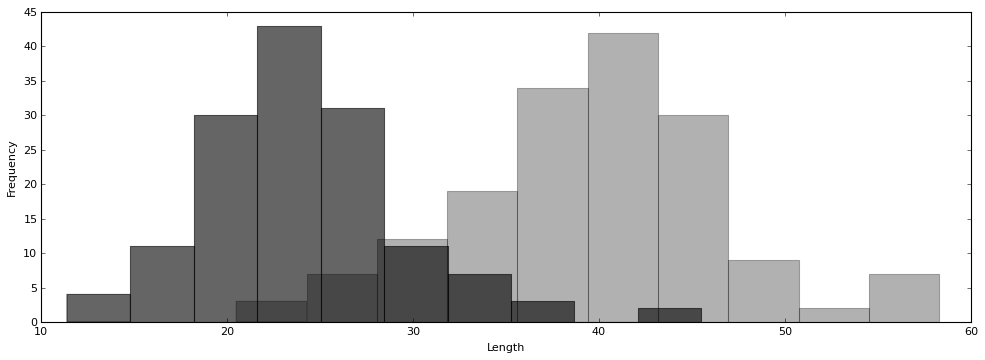

In [17]:
lengths = read_csv(data/'lengths.csv', sep=',')
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
for sex, color in zip(['M', 'F'], [.3, .6]):
    axes.hist(lengths.Length[lengths.Stage == sex].tolist(),
              alpha=color, color='k', normed=False)
axes.set_xlabel('Length')
axes.set_ylabel('Frequency')
fig.savefig('length.svg')
%Rpush lengths

On this graph are displayed the histograms of lengths for:

* females, in red,
* males, in blue.

In order to test if the sex has an influence on the length, we use the linear model

$$ l_i = \alpha_{s_i} + \epsilon_i,$$

where

*   $i$ denotes an individual.
*   $l_i$ is its length.
*   $\alpha_{s_i}$ is a coefficient depending on the sex of the individual.
    There two different coefficients : $\alpha_{F}$ for females and $\alpha_M$ for males.
*   $\epsilon_i$ is the Gaussian noise.

In [18]:
%%R
reg = lm('Length ~ Stage', data=lengths)
summary(reg)


Call:
lm(formula = "Length ~ Stage", data = lengths)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.2921  -3.5401   0.0079   3.2079  21.3599 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  24.1401     0.5285   45.67   <2e-16 ***
StageM       15.6520     0.7209   21.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.298 on 305 degrees of freedom
Multiple R-squared:  0.6071,	Adjusted R-squared:  0.6058 
F-statistic: 471.3 on 1 and 305 DF,  p-value: < 2.2e-16



On this table are displayed the estimated average length of:

* females, $\alpha_F = 24.14$ (first column on line (Intercept)) and significantly different from $0$ (last column on line (Intercept)),
* males, $\alpha_M = 24.14+15.65=39.79$ (first column on line (Intercept) plus the first column on line StageM) and significantly different from  the average of females (last column on line StageM).

The following plots can be used to verify the validity of linear model underlying hypotheses.
In particular:

* The top-left graph enable the verification of the homoscedasticity.
* The top-right graph enable the verification of the normality of errors.

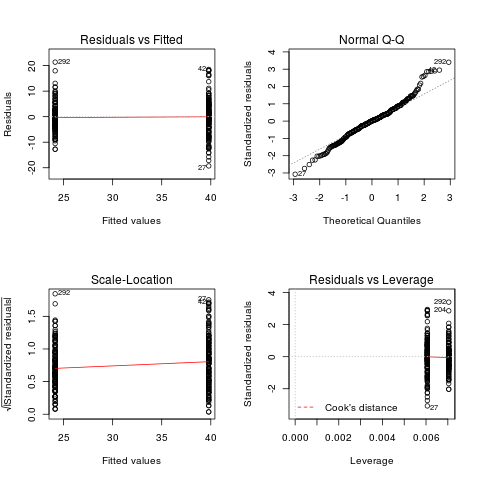

In [19]:
%%R
par(mfrow=c(2,2))
plot(reg)

Using the allometric relationships we display below the histogram of weights conditionally to the sex:

* In blue the histogram of male weights.
* In red the histogram of female weights.

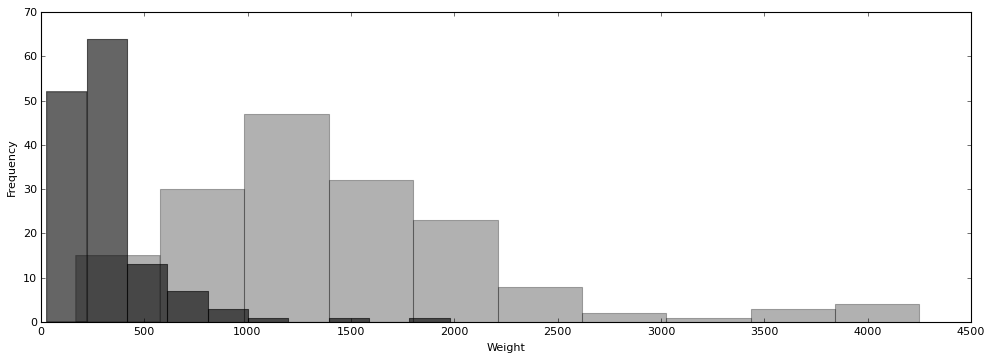

In [20]:
%Rpull coefficients
coefficients = np.array(coefficients)
alpha = math.exp(coefficients[0,0])
beta = coefficients[1,0]
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
for sex, color in zip(['M', 'F'], [.3, .6]):
    axes.hist([alpha*length**beta for length in lengths.Length[lengths.Stage == sex].tolist()],
              alpha=color, color='k', normed=False)
axes.set_xlabel('Weight')
axes.set_ylabel('Frequency')
fig.savefig('weight.svg')

In [21]:
coefficients.tolist()

[[-4.198408842717638,
  0.25539908540645584,
  -16.43862128964191,
  7.380141725945885e-17],
 [3.0876534537463587,
  0.07066535168802383,
  43.694022317724425,
  2.0447468909057848e-29]]

## Describing the reproductive behaviour of the species based on tangible quantitative data and explicit 3D representation of the spawning event.

### Preamble

Using [VTK](http://www.vtk.org/) to visualize frames.

In [22]:
from wanda.frame import vtk

To ease the *VTK* interactions we provide $3$ functions

* `renderers`, initialize differnt views of the same frame (e.g. one for viewing only males and one for viewing only females)
* `synchornize`, allow different views of the same frame (see above) to share the same camera in order to ease comparisons (when the camera of a view is moved, the other views moves in the same manner).
* `show`, is just an aggregation of *VTK* commands to display the frame and convert the selected view into a PNG image embedded in the notebook using [matplotlib](http://matplotlib.org/1.4.0/index.html) (if a name is provided, the image is written on the disk with the given name).

In [23]:
from wanda.frame import renderers, synchronize, show

A frame is represented by a set of $3$D points (columns **X**, **Y** and **Z**) associated to an indentifier (**Type**).
The identifier used are :

* G, for ground.
* M, for bodanius males.
* F, for bodanius females.

In [24]:
id_frame = 2
frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
frame

,Unnamed: 0,Type,Precision,RMS,Range,Direction,X,Y,Z
0,19,M,18841,3609,6946071,22366,-2495922,768215,-6436468
1,20,M,17684,121,6694072,20331,-2189589,684936,-6288653
2,21,M,10987,17919,5357418,12336,193847,-1210530,-5215263
3,22,M,14547,6941,6239373,9509,-988059,196378,-6157512
4,23,M,20899,1983,7628989,5484,-720332,-232559,-7591345
5,24,M,16463,14334,6695507,7474,627176,-709002,-6628256
6,25,M,15715,14497,6470704,13551,1380835,-725420,-6279895
7,26,M,10545,2483,5411748,15792,1469916,9920,-5208288
8,27,M,17165,8017,7098827,2423,-146014,150146,-7095737
9,28,M,22659,5080,7554364,15250,-1249228,1430011,-7311834


On each frame, bodanius are are represented by spheres

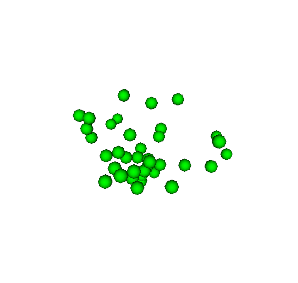

In [25]:
from wanda.frame import plot_spheres

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_spheres(frame[frame.Type != 'G'], renderer, 0., 1., 0., size=200000)

show(window)
del window

On each frame the ground is represented by a surface representing the delaunay triangulation of avaible points.

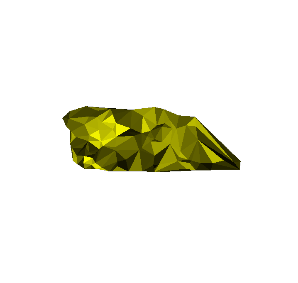

In [26]:
from wanda.frame import plot_delaunay_2D

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_delaunay_2D(frame[frame.Type == 'G'], renderer, 1., 1., 0.)

show(window)
del window

The resulting frame is a combination of:

* A yellow surface representing the ground.
* Blue spheres representing male bodanius.
* Red spheres representing female bodanius.

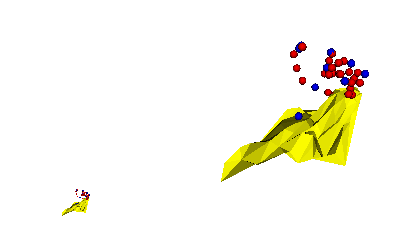

In [27]:
id_frame = 4
frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')

window = vtk.vtkRenderWindow()
renderer = renderers(window, 1,1).pop()

plot_spheres(frame[frame.Type == 'M'], renderer, 0., 0., 1., size=200000)
plot_spheres(frame[frame.Type == 'F'], renderer, 1., 0., 0., size=200000)
plot_delaunay_2D(frame[frame.Type == 'G'], renderer, 1., 1., 0.)

show(window, magnification=5, name='./frame.png')
del window

### Distances between individuals

Since the units of positions are in micrometers, one use the `SI` function to convert them into meters.

In [29]:
from wanda.tools import SI

In order to compare behaviours of males and females we consider sex minimal intra and inter-distances.
The minimal intra-distance is the minimal distance of one individual to another individual of the same sex.
*A contrario*, the minimal inter-distance is the minimal distance of one individual to another individual of the other sex.
These distances are displayed using conditional histograms for males (in blue) and females (in red) and statistically compared using:

* [Wilcoxon rank sum test](http://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test),
* Gamma [GLMs](http://en.wikipedia.org/wiki/Generalized_linear_model), 
* Model selection using the `step` function and the Bayesian Information Criterion ([BIC](http://en.wikipedia.org/wiki/Bayesian_information_criterion)).

The Wilcoxon rank sum test and Gamma GLMs are used since the obersations are clearly non-normal.

#### Intra-distances

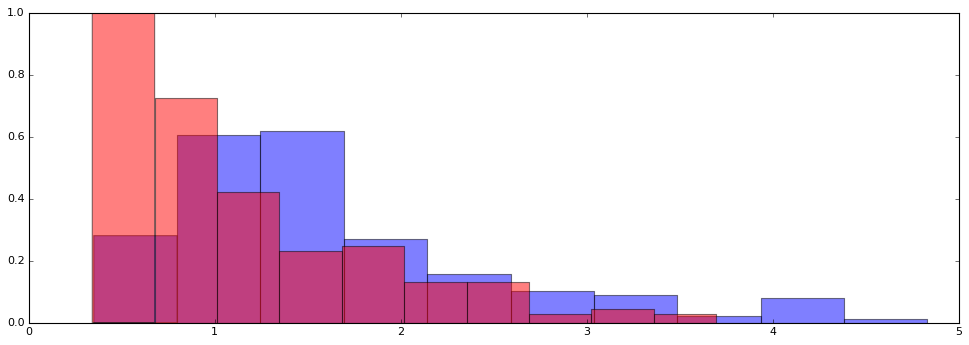

In [30]:
from wanda.distances import intra
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        if id_frame < 16:
            X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        else:
            X, Y, Z = SI(frame[frame.Type == sex], 'mm')
        for d in intra(X, Y, Z):
            frames.append([d, sex])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [31]:
%%R
wilcox.test(d ~ sex, data=frames)


	Wilcoxon rank sum test with continuity correction

data:  d by sex
W = 11759, p-value = 1.166e-13
alternative hypothesis: true location shift is not equal to 0



In [32]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)


Call:
glm(formula = d ~ sex, family = Gamma, data = frames)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2279  -0.5199  -0.2147   0.1997   1.4972  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.89874    0.03703  24.269  < 2e-16 ***
sexM        -0.28610    0.04507  -6.348 5.88e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3498013)

    Null deviance: 137.38  on 404  degrees of freedom
Residual deviance: 122.57  on 403  degrees of freedom
AIC: 808.07

Number of Fisher Scoring iterations: 5



In [33]:
%%R
attributes(reg)

$names
 [1] "coefficients"      "residuals"         "fitted.values"    
 [4] "effects"           "R"                 "rank"             
 [7] "qr"                "family"            "linear.predictors"
[10] "deviance"          "aic"               "null.deviance"    
[13] "iter"              "weights"           "prior.weights"    
[16] "df.residual"       "df.null"           "y"                
[19] "converged"         "boundary"          "model"            
[22] "call"              "formula"           "terms"            
[25] "data"              "offset"            "control"          
[28] "method"            "contrasts"         "xlevels"          

$class
[1] "glm" "lm" 



In [34]:
%%R
step(reg, k = log(reg$n))

Start:  AIC=813.92
d ~ sex

       Df Deviance    AIC
<none>      122.57 813.92
- sex   1   137.38 851.33

Call:  glm(formula = d ~ sex, family = Gamma, data = frames)

Coefficients:
(Intercept)         sexM  
     0.8987      -0.2861  

Degrees of Freedom: 404 Total (i.e. Null);  403 Residual
Null Deviance:	    137.4 
Residual Deviance: 122.6 	AIC: 808.1


The three approaches (Test, GLMs+Test and Model selection) are considering that intra-distances within females and within males are significatively different.
Males tend to be less close than females.

#### Inter-distances

Inter-distances are not really relevant and are not significatively different.
The approach below comparing intra-distances to inter-distances seems to be more relevant.

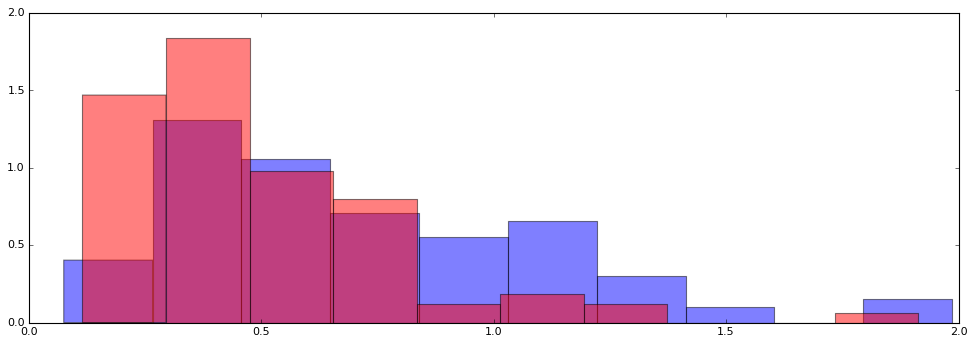

In [35]:
from wanda.distances import inter
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        if id_frame < 16:
            X0, Y0, Z0 = SI(frame[frame.Type == sex], 'micro')
            X1, Y1, Z1 = SI(frame[frame.Type == 'G'], 'micro')
        else:
            X0, Y0, Z0 = SI(frame[frame.Type == sex], 'mm')
            X1, Y1, Z1 = SI(frame[frame.Type == 'G'], 'mm')
        for d in inter(X0, Y0, Z0, X1, Y1, Z1):
            frames.append([d, sex])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [36]:
%%R
wilcox.test(d ~ sex, data=frames)


	Wilcoxon rank sum test with continuity correction

data:  d by sex
W = 3065, p-value = 2.248e-05
alternative hypothesis: true location shift is not equal to 0



In [37]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)


Call:
glm(formula = d ~ sex, family = Gamma, data = frames)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6459  -0.4962  -0.1686   0.2953   1.7357  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.0157     0.1236  16.308  < 2e-16 ***
sexM         -0.6190     0.1473  -4.202 4.03e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3422079)

    Null deviance: 69.885  on 194  degrees of freedom
Residual deviance: 63.441  on 193  degrees of freedom
AIC: 90.443

Number of Fisher Scoring iterations: 5



In [38]:
%%R
step(reg, k = log(reg$n))

Start:  AIC=94.94
d ~ sex

       Df Deviance     AIC
<none>      63.441  94.937
- sex   1   69.885 109.521

Call:  glm(formula = d ~ sex, family = Gamma, data = frames)

Coefficients:
(Intercept)         sexM  
      2.016       -0.619  

Degrees of Freedom: 194 Total (i.e. Null);  193 Residual
Null Deviance:	    69.89 
Residual Deviance: 63.44 	AIC: 90.44


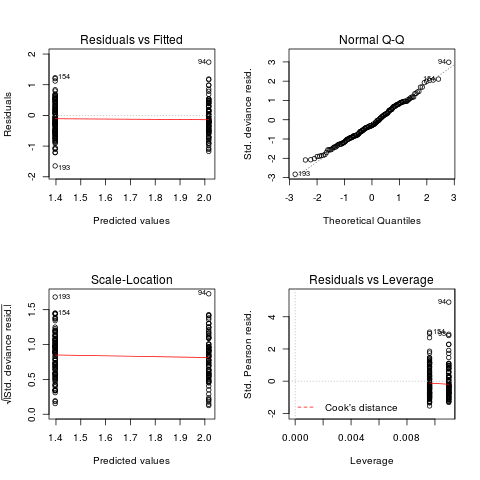

In [39]:
%%R
par(mfrow=c(2,2))
plot(reg)

#### Comparison of inter and intra-distances

We compare hereabove the intra and inter-distances for males and females.
For both, after a statistical analysis it appears that males are closest to females than to males and vice-versa.

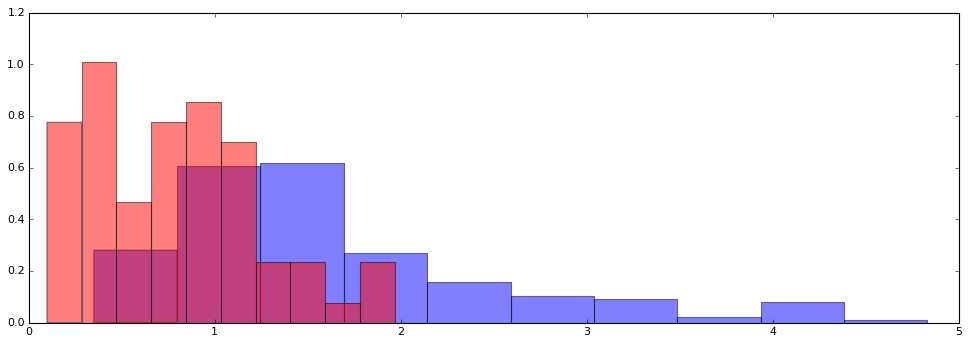

In [40]:
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    if id_frame < 16:
        X0, Y0, Z0 = SI(frame[frame.Type == 'M'], 'micro')
        X1, Y1, Z1 = SI(frame[frame.Type == 'F'], 'micro')
    else:
        X0, Y0, Z0 = SI(frame[frame.Type == 'M'], 'mm')
        X1, Y1, Z1 = SI(frame[frame.Type == 'F'], 'mm')  
    for d in inter(X0, Y0, Z0, X1, Y1, Z1):
        frames.append([d, 'F'])
    for d in intra(X0, Y0, Z0):
        frames.append([d, 'M'])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [41]:
%%R
wilcox.test(d ~ sex, data=frames)


	Wilcoxon rank sum test with continuity correction

data:  d by sex
W = 2292, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0



In [42]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)


Call:
glm(formula = d ~ sex, family = Gamma, data = frames)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5478  -0.4688  -0.1550   0.1913   1.3228  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.28133    0.08423  15.213  < 2e-16 ***
sexM        -0.66870    0.08750  -7.642 3.88e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.29814)

    Null deviance: 100.65  on 267  degrees of freedom
Residual deviance:  76.16  on 266  degrees of freedom
AIC: 526.67

Number of Fisher Scoring iterations: 5



In [43]:
%%R
step(reg, k = log(reg$n))

Start:  AIC=531.89
d ~ sex

       Df Deviance    AIC
<none>       76.16 531.89
- sex   1   100.65 609.42

Call:  glm(formula = d ~ sex, family = Gamma, data = frames)

Coefficients:
(Intercept)         sexM  
     1.2813      -0.6687  

Degrees of Freedom: 267 Total (i.e. Null);  266 Residual
Null Deviance:	    100.6 
Residual Deviance: 76.16 	AIC: 526.7


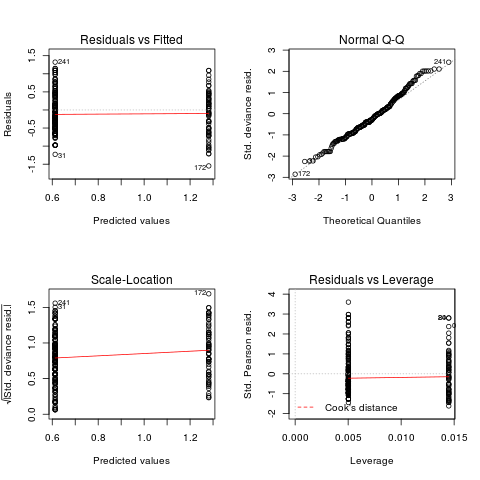

In [44]:
%%R
par(mfrow=c(2,2))
plot(reg)

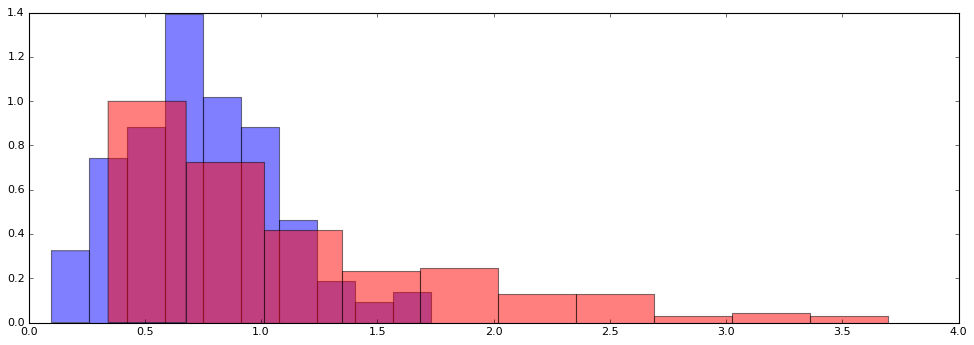

In [45]:
frames = []
for id_frame in range(1,20):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    if id_frame < 16:
        X0, Y0, Z0 = SI(frame[frame.Type == 'F'], 'micro')
        X1, Y1, Z1 = SI(frame[frame.Type == 'M'], 'micro')
    else:
        X0, Y0, Z0 = SI(frame[frame.Type == 'F'], 'mm')
        X1, Y1, Z1 = SI(frame[frame.Type == 'M'], 'mm')
    for d in inter(X0, Y0, Z0, X1, Y1, Z1):
        frames.append([d, 'M'])
    for d in intra(X0, Y0, Z0):
        frames.append([d, 'F'])
frames = DataFrame(data=frames, columns=['d', 'sex'])
%Rpush frames
fig = plt.figure(figsize=(15,5))
axes = fig.add_subplot(1,1,1)
histM = axes.hist(frames[frames.sex == 'M'].d.tolist(), alpha=.5, color='b', normed=True)
histF = axes.hist(frames[frames.sex == 'F'].d.tolist(), alpha=.5, color='r', normed=True)

In [46]:
%%R
aggregate(frames, list(Sex = frames$sex), summary)

  Sex  d.Min. d.1st Qu. d.Median  d.Mean d.3rd Qu.  d.Max. sex.F sex.M
1   F 0.34200   0.58160  0.87490 1.11300   1.51300 3.69500   206     0
2   M 0.09829   0.55110  0.71100 0.74680   0.94020 1.73200     0   132


In [47]:
%%R
wilcox.test(d ~ sex, data=frames)


	Wilcoxon rank sum test with continuity correction

data:  d by sex
W = 17152, p-value = 4.952e-05
alternative hypothesis: true location shift is not equal to 0



In [48]:
%%R
reg = glm(d~sex,family=Gamma, data=frames)
summary(reg)


Call:
glm(formula = d ~ sex, family = Gamma, data = frames)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5228  -0.5852  -0.1793   0.2993   1.4972  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.89874    0.03568   25.19  < 2e-16 ***
sexM         0.44034    0.07540    5.84 1.23e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.3247741)

    Null deviance: 114.04  on 337  degrees of freedom
Residual deviance: 101.69  on 336  degrees of freedom
AIC: 441.33

Number of Fisher Scoring iterations: 5



In [49]:
%%R
step(reg, k = log(reg$n))

Start:  AIC=446.81
d ~ sex

       Df Deviance    AIC
<none>      101.69 446.81
- sex   1   114.04 480.11

Call:  glm(formula = d ~ sex, family = Gamma, data = frames)

Coefficients:
(Intercept)         sexM  
     0.8987       0.4403  

Degrees of Freedom: 337 Total (i.e. Null);  336 Residual
Null Deviance:	    114 
Residual Deviance: 101.7 	AIC: 441.3


## Providing estimates of abundance and volumetric density of fish using individual 3D coordinates

Using convex hulls we are able to estimate the density of a set of fish.

In [50]:
from wanda.concentration import convex_hull_concentration
frames = []
for id_frame in range(1,13):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex in ['F', 'M']:
        X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        c = convex_hull_concentration(X, Y, Z, nmin=3)
        frames.append([c, sex])
frames = DataFrame(data=frames, columns=['c', 'sex'])
%Rpush frames
frames.dropna(0, 'any')

,c,sex
0,2.450088,F
1,1.228412,M
2,3.620624,F
3,1.186523,M
4,3.429632,F
5,1.091303,M
6,5.168258,F
7,1.601316,M
8,2.203265,F
9,2.369772,M


Given the number of frames the data is limited.
Nevertheless males and females could be compared using Wilcoxon rank sum test for instances.

In [51]:
%%R
wilcox.test(c ~ sex, data=frames)


	Wilcoxon rank sum test

data:  c by sex
W = 60, p-value = 0.01357
alternative hypothesis: true location shift is not equal to 0



But this approach is not entirely satisfying since one compare densities between different frames.
Fish groups are therefore have not the same size and it could be relevant only if fishes are uniformly distributed into their convex hull.
In order to investigate this property we considered the density as a function of the distance of the barycenter of fish groups.
As illustrated on the below (log of density as function of the log distance to the barycenter) the fishes are clearly not uniformly distributed into their convex-hulls.

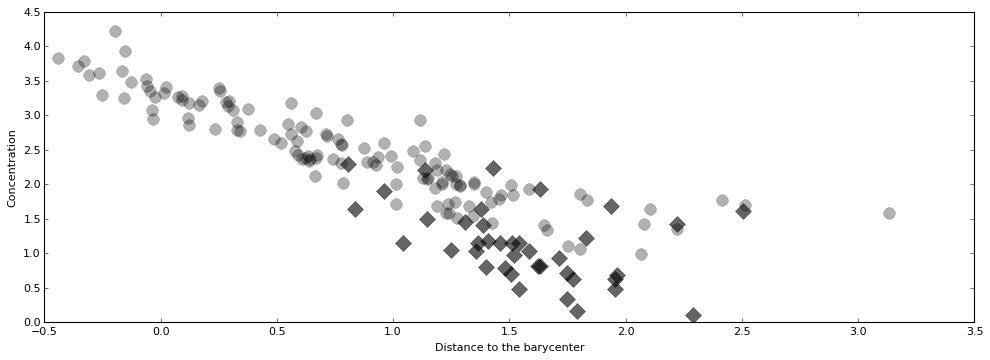

In [52]:
from wanda.concentration import radiuses
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
logx = True
logy = True
frames = []
for id_frame in range(1,13):
    frame = read_csv(data/'frame_'+str(id_frame)+'/points.csv', sep='\t')
    for sex, color in zip(['F', 'M'], ['ko', 'kD']):
        X, Y, Z = SI(frame[frame.Type == sex], 'micro')
        r = radiuses(X, Y, Z)
        c = [convex_hull_concentration(X, Y, Z, i, nmin=7) for i in r]
        if logx:
            r = [math.log(r) for r in r]
        if logy:
            c = [math.log(c) for c in c]
        plt.plot(r,c,color, markersize=10., alpha=.3+.3*(sex=='M'))
        for r, c in zip(r, c):
            frames.append([r, c, sex])
axes.set_xlabel('Distance to the barycenter')
axes.set_ylabel('Concentration')
frames = DataFrame(data=frames, columns=['r', 'c', 'sex'])
fig.savefig('density.svg')
%Rpush frames

In fact, it seems that for a group $i$ of individuals of same sex $s_i$: 

$$ \log(d_i) = \alpha_{s_i} + \beta_{s_i} \times r_i + \epsilon_i$$

where:

* $d_i$ is the density of the group,
* $r_i$ is the maximal distance to the barycenter encountered in the group $i$,
* $\epsilon_i$

In [53]:
%%R
reg = lm('c ~ r * sex', data=frames)
summary(reg)


Call:
lm(formula = "c ~ r * sex", data = frames)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.80550 -0.23397 -0.01438  0.14569  1.22272 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.23361    0.04938  65.483  < 2e-16 ***
r           -0.91688    0.04654 -19.703  < 2e-16 ***
sexM        -1.02108    0.25270  -4.041 8.19e-05 ***
r:sexM       0.22339    0.16192   1.380     0.17    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3541 on 163 degrees of freedom
  (135 observations deleted due to missingness)
Multiple R-squared:  0.8376,	Adjusted R-squared:  0.8346 
F-statistic: 280.3 on 3 and 163 DF,  p-value: < 2.2e-16



In [54]:
%%R
step(reg)

Start:  AIC=-342.78
c ~ r * sex

        Df Sum of Sq    RSS     AIC
- r:sex  1   0.23869 20.680 -342.84
<none>               20.441 -342.78

Step:  AIC=-342.84
c ~ r + sex

       Df Sum of Sq    RSS     AIC
<none>              20.679 -342.84
- sex   1     11.24 31.919 -272.35
- r     1     50.95 71.629 -137.36

Call:
lm(formula = c ~ r + sex, data = frames)

Coefficients:
(Intercept)            r         sexM  
     3.2185      -0.8984      -0.6871  



When fitting the linear model to data, both test and model selection approaches propose to consider the following model (the slope is not depending on the sex) :

$$ \log(d_i) = \alpha_{s_i} + \beta \times r_i + \epsilon_i$$

This is particularly interesting since the difference between males and females is therefore only concerning the intercept.
Then

$$\forall r \in \mathbb{R}^+, \quad \frac{d_M}{d_F} = \exp(\alpha_{M}-\alpha_{F}) $$

can be used to compare densities.

In [64]:
%%R
reg = lm('c ~ r + sex', data=frames)
coefficients = summary(reg)$coefficients
prd = predict(reg, na.action = na.exclude)
summary(reg)


Call:
lm(formula = "c ~ r + sex", data = frames)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75758 -0.22691 -0.02436  0.14913  1.32342 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.21846    0.04828  66.665   <2e-16 ***
r           -0.89843    0.04470 -20.101   <2e-16 ***
sexM        -0.68714    0.07278  -9.441   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3551 on 164 degrees of freedom
  (135 observations deleted due to missingness)
Multiple R-squared:  0.8357,	Adjusted R-squared:  0.8337 
F-statistic: 417.2 on 2 and 164 DF,  p-value: < 2.2e-16



From this table we have $\alpha_M - \alpha_F = -0.68714$.
For a same radius of an enclosing circle, the density of females is therefore $\frac{1}{\exp(-0.68714)} \approx \frac{1}{.50} \approx 2.$ times higher that the one of males.

In [88]:
newframes = DataFrame(data=[[-.5, 'M'], [3.5, "M"]], columns=['r', 'sex'])
newframes
%Rpush newframes

In [89]:
%%R
Mpred = predict(reg, newframes)

In [90]:
newframes = DataFrame(data=[[-.5, 'F'], [3.5, "F"]], columns=['r', 'sex'])
newframes
%Rpush newframes

In [91]:
%%R
Fpred = predict(reg, newframes)

In [85]:
%Rpull Fpred
list(Fpred)

[3.667678681596427, 0.0739509991486722]

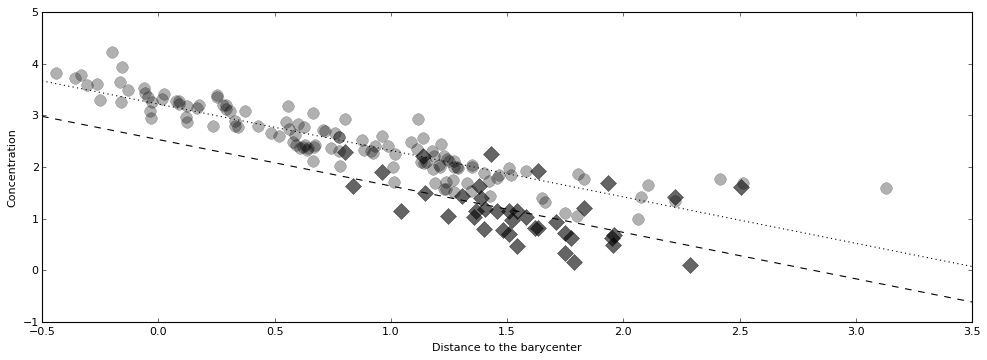

In [101]:
%Rpull Mpred
%Rpull Fpred
fig = plt.figure(figsize=(15,5))
axes = plt.subplot(1,1,1)
axes.plot(frames.r[frames.sex == 'F'], frames.c[frames.sex == 'F'], 'ko', markersize=10., alpha=.3)
axes.plot(frames.r[frames.sex == 'M'], frames.c[frames.sex == 'M'], 'kD', markersize=10., alpha=.6)
axes.plot([-.5, 3.5], list(Fpred), 'k:')
axes.plot([-.5, 3.5], list(Mpred), 'k--')
axes.set_xlabel('Distance to the barycenter')
axes.set_ylabel('Concentration')
fig.savefig('density.svg')